Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import zipfile
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import random

In [2]:
%matplotlib inline

In [3]:
from tinyVIT import ViT, MAE, CatsDogsDataset


In [4]:
savepath = "mae_trained.pt"

In [5]:
device="cuda"

In [6]:
model = ViT(
        dim=128,
        image_size=224,
        patch_size=32,
        num_classes=2,
        channels=3,
        depth = 3,
        heads =4,
        mlp_dim = 2048,
        dropout = 0.1,
        emb_dropout = 0.1
        
).to(device)

mae = MAE(
    encoder = model,
    masking_ratio = 0.1,   # the paper recommended 75% masked patches
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
).to(device)

image_height image_width 224
patch_height patch_width 32
patch_dim 3072
num_patches 49


In [7]:
checkpoint = torch.load(savepath)
model.load_state_dict(checkpoint['model'])
mae.load_state_dict(checkpoint['mae'])

<All keys matched successfully>

In [8]:
base_dir = "/home/msalvaris/data/dogs-vs-cats-redux-kernels-edition"
train_list = glob.glob(os.path.join(base_dir,"train",'*.jpg'))
test_list = glob.glob(os.path.join(base_dir, "test", '*.jpg'))

In [9]:
test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [10]:
valid_data = CatsDogsDataset(test_list, transform=test_transforms)

In [11]:
valid_loader = DataLoader(dataset=valid_data, batch_size=8, shuffle=False, num_workers=8)

In [12]:
with torch.no_grad():
    for data, label in valid_loader:
        data = data.to(device)
        val_output = mae.predict_pixels(data)
        break

In [13]:
val_output.shape

torch.Size([8, 49, 3072])

In [14]:
patch_height = patch_width = 32

In [15]:
val_output.shape

torch.Size([8, 49, 3072])

In [16]:
a_star = rearrange(val_output, 'b (h w) (p1 p2 c) -> b (h p1) (w p2) c', p1 = patch_height, p2 = patch_width,h=7,w=7)

In [17]:
a_star.shape

torch.Size([8, 224, 224, 3])

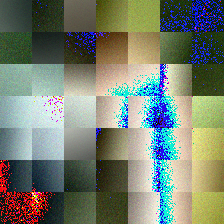

In [27]:
Image.fromarray((a_star[7,:,:].detach().cpu().numpy()*255).astype(np.uint8))

In [19]:
data2 = rearrange(data, 'b c h w -> b h w c')

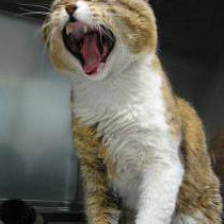

In [28]:
Image.fromarray((data2[7,:,:].detach().cpu().numpy()*255).astype(np.uint8))

In [47]:
new_a = rearrange(a, 'h w c -> (h w c)', c=3, h=32, w=32)

In [51]:
new_a

array([1., 2., 3., ..., 1., 2., 3.])

In [48]:
a_star = rearrange(new_a, '(h w c) -> h w c', c=3, h=32, w=32)

In [50]:
a_star[:,:,0]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [63]:
224*224

50176

In [65]:
49*32*32

50176

In [66]:
224/32

7.0

In [67]:
7*7*3

147

In [58]:
one_output = rearrange(val_output[0,:,:], 'p (h w c) -> h w c', c=3, h=32, w=32)

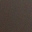

In [59]:
Image.fromarray((one_output.detach().cpu().numpy()*255).astype(np.uint8))

In [19]:
# Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
back_to_image = Rearrange('b (h w) (p1 p2 c) -> b c (h p1) (w p2)', p1 = patch_height, p2 = patch_width, w=224, h=224)

In [ ]:
val_output

In [24]:
reshaped_tensor = rearrange(val_output[:,:48,:], 'b p (c h w) -> b c h w', c=3, h=224, w=244)

EinopsError:  Error while processing rearrange-reduction pattern "b p (c h w) -> b c h w".
 Input tensor shape: torch.Size([8, 48, 3072]). Additional info: {'c': 3, 'h': 224, 'w': 244}.
 Identifiers only on one side of expression (should be on both): {'p'}

In [22]:
49*3072

150528

In [21]:
224*224

50176

In [20]:
back_to_image(val_output).shape

EinopsError: Shape mismatch, 49 != 50176